In [66]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

## Preprocessing

### Load Images

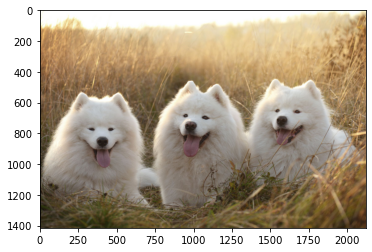

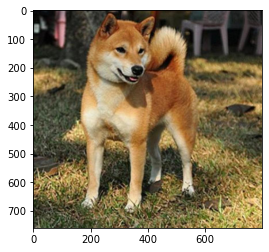

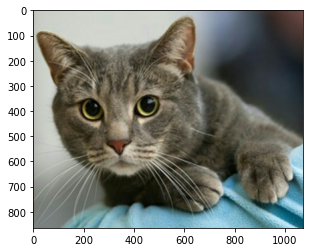

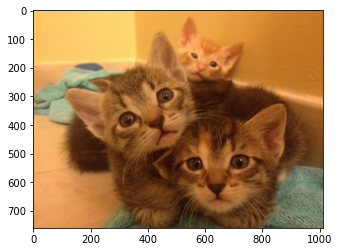

In [67]:
img1 = plt.imread("images/image1.jpg")
img2  = plt.imread("images/image2.jpg") 
img3  = plt.imread("images/image3.jpg") 
img4  = plt.imread("images/image4.jpg")  

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

plt.imshow(img3)
plt.show()

plt.imshow(img4)
plt.show()

### RGB to Gray

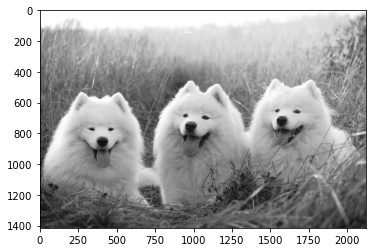

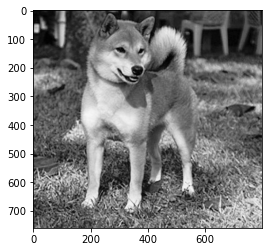

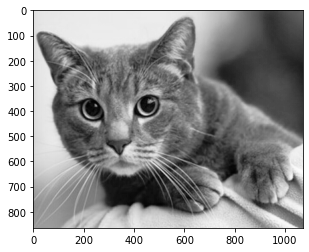

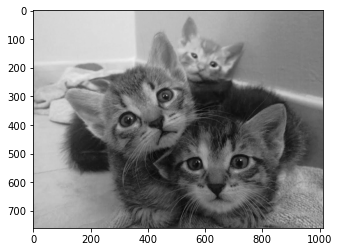

In [68]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_gray, cmap='Greys_r')
plt.show()

img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(img2_gray, cmap='Greys_r')
plt.show()

img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
plt.imshow(img3_gray, cmap='Greys_r')
plt.show()

img4_gray = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
plt.imshow(img4_gray, cmap='Greys_r')
plt.show()

### Image Resize

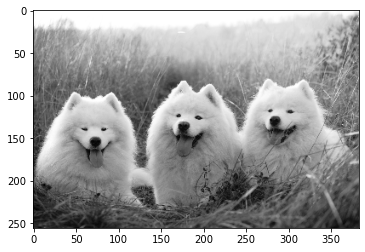

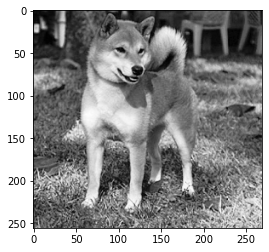

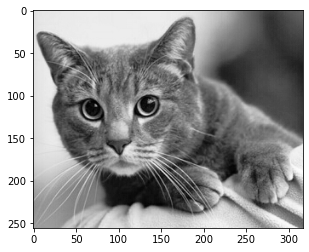

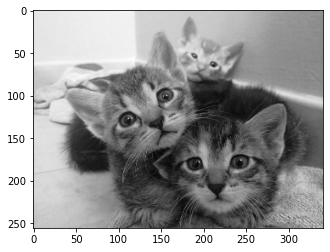

In [69]:
img1_gray = cv2.resize(img1_gray, (int(img1.shape[1] / img1.shape[0] * 256), 256))
plt.imshow(img1_gray, cmap='Greys_r')
plt.show()

img2_gray = cv2.resize(img2_gray, (int(img2.shape[1] / img2.shape[0] * 256), 256))
plt.imshow(img2_gray, cmap='Greys_r')
plt.show()

img3_gray = cv2.resize(img3_gray, (int(img3.shape[1] / img3.shape[0] * 256), 256))
plt.imshow(img3_gray, cmap='Greys_r')
plt.show()

img4_gray = cv2.resize(img4_gray, (int(img4.shape[1] / img4.shape[0] * 256), 256))
plt.imshow(img4_gray, cmap='Greys_r')
plt.show()

## Canny Edge Detection

### Module

In [70]:
class Canny():
    def gaussian_filter(image, kernel=3, sigma=1):
        padding = kernel//2
        stride = 1
        
        temp = np.zeros((image.shape[0] + 2*padding, image.shape[1] + 2*padding))  
        blur = np.zeros((image.shape[0], image.shape[1]))  

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                temp[i+padding][j+padding] = image[i][j]
        
        x, y = np.mgrid[-(kernel//2):(kernel//2)+1, -(kernel//2):(kernel//2)+1]
        gaussian_kernel = (1/(2*math.pi*sigma**2))*np.exp(-(x**2+y**2)/(2*(sigma**2)))

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                blur[i][j] = (temp[stride*i:stride*i+kernel, stride*j:stride*j+kernel]*gaussian_kernel).sum()
                
        return blur
    
    def sobel_filter(image):
        convolved = np.zeros(image.shape)
        G_x = np.zeros(image.shape)
        G_y = np.zeros(image.shape)
        size = image.shape
        kernel_x = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
        kernel_y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
        
        for i in range(1, size[0] - 1):
            for j in range(1, size[1] - 1):
                G_x[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_x))
                G_y[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_y))
        
        convolved = np.sqrt(np.square(G_x) + np.square(G_y))
        convolved = np.multiply(convolved, 255.0 / convolved.max())

        angles = np.rad2deg(np.arctan2(G_y, G_x))
        angles[angles < 0] += 180
        convolved = convolved.astype('uint8')
        
        return convolved, angles
    
    def non_max_suppression(image, angles):
        size = image.shape
        suppressed = np.zeros(size)
        
        for i in range(1, size[0] - 1):
            for j in range(1, size[1] - 1):
                if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                    value_to_compare = max(image[i, j - 1], image[i, j + 1])
                elif (22.5 <= angles[i, j] < 67.5):
                    value_to_compare = max(image[i - 1, j - 1], image[i + 1, j + 1])
                elif (67.5 <= angles[i, j] < 112.5):
                    value_to_compare = max(image[i - 1, j], image[i + 1, j])
                else:
                    value_to_compare = max(image[i + 1, j - 1], image[i - 1, j + 1])
                
                if image[i, j] >= value_to_compare:
                    suppressed[i, j] = image[i, j]
        suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
        
        return suppressed
    
    def double_threshold(image, low, high):
        weak = 50
        strong = 255
        size = image.shape
        result = np.zeros(size)
        weak_x, weak_y = np.where((image > low) & (image <= high))
        strong_x, strong_y = np.where(image >= high)
        result[strong_x, strong_y] = strong
        result[weak_x, weak_y] = weak
        dx = np.array((-1, -1, 0, 1, 1, 1, 0, -1))
        dy = np.array((0, 1, 1, 1, 0, -1, -1, -1))
        size = image.shape
        
        while len(strong_x):
            x = strong_x[0]
            y = strong_y[0]
            strong_x = np.delete(strong_x, 0)
            strong_y = np.delete(strong_y, 0)
            for direction in range(len(dx)):
                new_x = x + dx[direction]
                new_y = y + dy[direction]
                if((new_x >= 0 & new_x < size[0] & new_y >= 0 & new_y < size[1]) and (result[new_x, new_y]  == weak)):
                    result[new_x, new_y] = strong
                    np.append(strong_x, new_x)
                    np.append(strong_y, new_y)
        result[result != strong] = 0
        
        return result

### Gaussian Filter

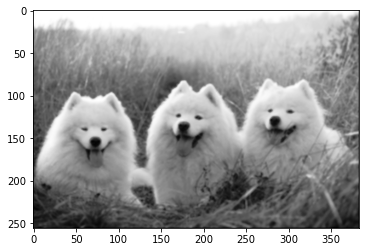

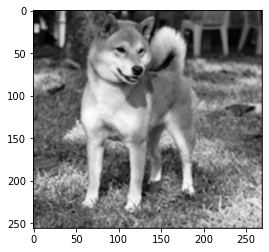

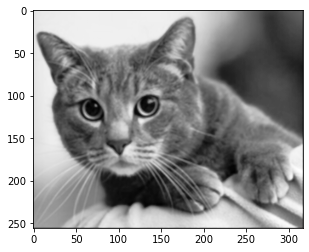

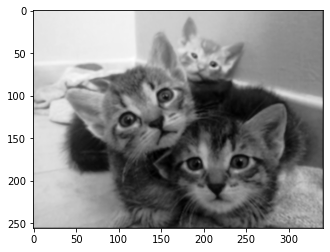

In [71]:
img1 = Canny.gaussian_filter(img1_gray)
plt.imshow(img1, cmap='Greys_r')
plt.show()

img2 = Canny.gaussian_filter(img2_gray)
plt.imshow(img2, cmap='Greys_r')
plt.show()

img3 = Canny.gaussian_filter(img3_gray)
plt.imshow(img3, cmap='Greys_r')
plt.show()

img4 = Canny.gaussian_filter(img4_gray)
plt.imshow(img4, cmap='Greys_r')
plt.show()

### Sobel Filter

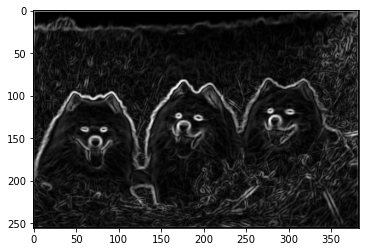

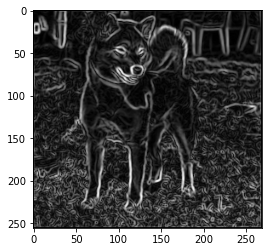

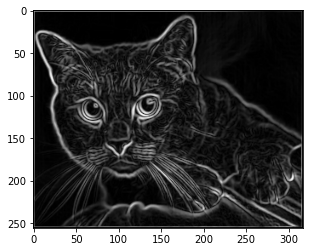

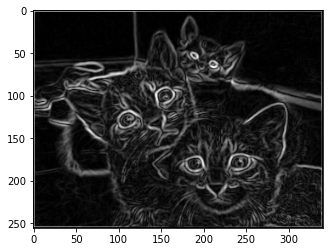

In [72]:
img1, angle1 = Canny.sobel_filter(img1)
plt.imshow(img1, cmap='Greys_r')
plt.show()

img2, angle2 = Canny.sobel_filter(img2)
plt.imshow(img2, cmap='Greys_r')
plt.show()

img3, angle3 = Canny.sobel_filter(img3)
plt.imshow(img3, cmap='Greys_r')
plt.show()

img4, angle4 = Canny.sobel_filter(img4)
plt.imshow(img4, cmap='Greys_r')
plt.show()

### Non-maximum Suppression

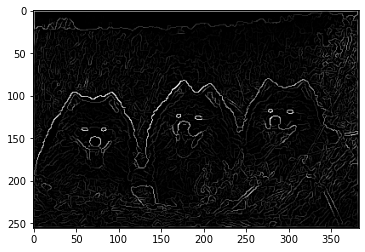

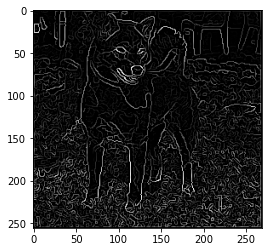

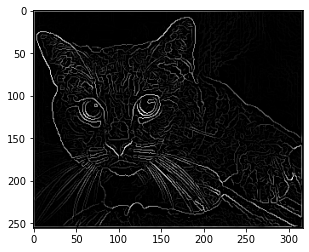

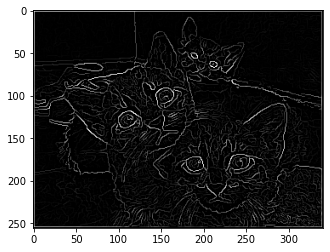

In [73]:
img1 = Canny.non_max_suppression(img1, angle1)
plt.imshow(img1, cmap='Greys_r')
plt.show()

img2 = Canny.non_max_suppression(img2, angle2)
plt.imshow(img2, cmap='Greys_r')
plt.show()

img3 = Canny.non_max_suppression(img3, angle3)
plt.imshow(img3, cmap='Greys_r')
plt.show()

img4 = Canny.non_max_suppression(img4, angle4)
plt.imshow(img4, cmap='Greys_r')
plt.show()

### Double Threshold

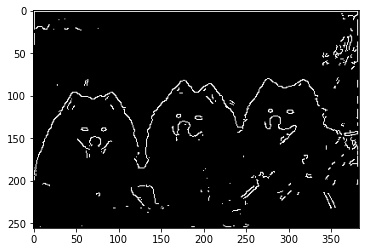

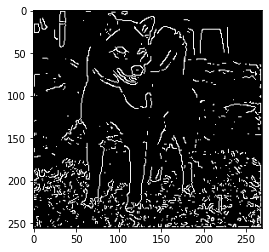

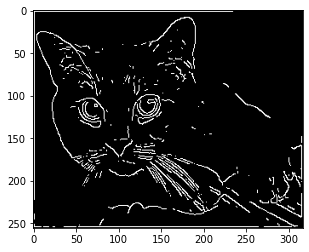

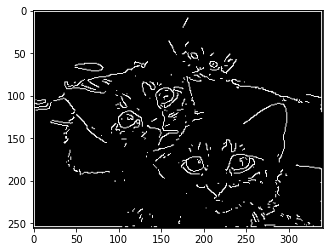

In [74]:
img1_result = Canny.double_threshold(img1, 30, 70)
plt.imshow(img1_result, cmap='Greys_r')
plt.show()

img2_result = Canny.double_threshold(img2, 30, 70)
plt.imshow(img2_result, cmap='Greys_r')
plt.show()

img3_result = Canny.double_threshold(img3, 30, 70)
plt.imshow(img3_result, cmap='Greys_r')
plt.show()

img4_result = Canny.double_threshold(img4, 30, 70)
plt.imshow(img4_result, cmap='Greys_r')
plt.show()

## Compare to OpenCV cv2.Canny()

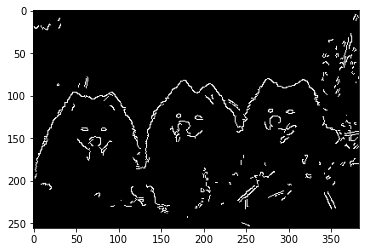

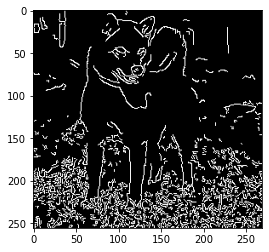

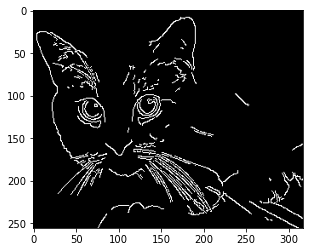

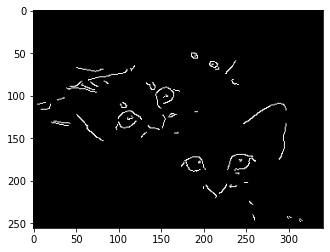

In [80]:
img1_result = cv2.Canny(img1_gray, 200, 300)
plt.imshow(img1_result, cmap='Greys_r')
plt.show()

img2_result = cv2.Canny(img2_gray, 200, 300)
plt.imshow(img2_result, cmap='Greys_r')
plt.show()

img3_result = cv2.Canny(img3_gray, 200, 300)
plt.imshow(img3_result, cmap='Greys_r')
plt.show()

img4_result = cv2.Canny(img4_gray, 200, 300)
plt.imshow(img4_result, cmap='Greys_r')
plt.show()